In [9]:
from pathlib import Path
from tifffile import imread, imwrite
import numpy as np
import sys
sys.path.append("../")
from plots import *
from utils import *

SAVE_AS_SVG = True
SAVE_AS_PNG = False

In [10]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG/TRAINING"
gt_path = DATA_PATH / "dataset_float32/labels/semantic"

models_pred_path = [(DATA_PATH / f"fold{i+1}").resolve() for i in range(3)] 

In [11]:
gt_images = {}
# load images in gt_path
for img_path in gt_path.glob("*.tif"):
    img = imread(img_path)
    gt_images[img_path.stem[:2]] = img

In [12]:
# for each fold and model, the goal is to compute what is the best threshold for the model, based on Dice between the GT and the prediction
dices_df = pd.DataFrame(columns=["Image", "Threshold", "Dice", "Fold"])
for model_pred_path in models_pred_path:
    print("Fold : ", model_pred_path.name)
    preds_path = model_pred_path / "cellpose" 
    for i, img_path in enumerate(preds_path.glob("*.tif")):
        img_name = img_path.stem
        print(f"Image: {img_name[:2]}")
        img = imread(img_path)
        gt = gt_images[img_name[:2]]
        thresh = int(img_path.stem.split("_t_")[1].split(".")[0])
        print("Threshold: ", thresh)
        # gt = np.where(gt > 0, 1, 0) 3 already semantic
        pred = np.where(img > 0, 1, 0)
        dice = dice_coeff(y_true=gt, y_pred=pred)
        fold_name = model_pred_path.name 
        fold_name = fold_name[0].upper() + fold_name[1:].split("d")[0] + "d " + fold_name.split("d")[1]
        dices_df.loc[len(dices_df.index)] = [img_name[:2], thresh, dice, fold_name]

Fold :  fold1
Image: c1
Threshold:  -1
Image: c1
Threshold:  -10
Image: c1
Threshold:  -11
Image: c1
Threshold:  -12
Image: c1
Threshold:  -2
Image: c1
Threshold:  -3
Image: c1
Threshold:  -4
Image: c1
Threshold:  -5
Image: c1
Threshold:  -6
Image: c1
Threshold:  -7
Image: c1
Threshold:  -8
Image: c1
Threshold:  -9
Image: c1
Threshold:  0
Image: c1
Threshold:  1
Image: c1
Threshold:  10
Image: c1
Threshold:  11
Image: c1
Threshold:  12
Image: c1
Threshold:  2
Image: c1
Threshold:  3
Image: c1
Threshold:  4
Image: c1
Threshold:  5
Image: c1
Threshold:  6
Image: c1
Threshold:  7
Image: c1
Threshold:  8
Image: c1
Threshold:  9
Image: c2
Threshold:  -1
Image: c2
Threshold:  -10
Image: c2
Threshold:  -11
Image: c2
Threshold:  -12
Image: c2
Threshold:  -2
Image: c2
Threshold:  -3
Image: c2
Threshold:  -4
Image: c2
Threshold:  -5
Image: c2
Threshold:  -6
Image: c2
Threshold:  -7
Image: c2
Threshold:  -8
Image: c2
Threshold:  -9
Image: c2
Threshold:  0
Image: c2
Threshold:  1
Image: c2
Thresho

In [13]:
dices_df.sort_values(by="Threshold", inplace=True)
dices_df

,Image,Threshold,Dice,Fold
278,c2,-12,0.775973,Fold 3
78,c4,-12,0.797301,Fold 1
303,c4,-12,0.800392,Fold 3
153,c2,-12,0.759762,Fold 2
328,c5,-12,0.822107,Fold 3
...,...,...,...,...
116,c5,12,0.068623,Fold 1
291,c2,12,0.049552,Fold 3
91,c4,12,0.074260,Fold 1
41,c2,12,0.098026,Fold 1


In [14]:
dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])

C:\Users\Cyril\AppData\Local\Temp\ipykernel_6456\971282983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])


,Image,Threshold,Dice,Fold
Fold,,,,
Fold 1,c5,-11,0.820466,Fold 1
Fold 2,vi,-7,0.820637,Fold 2
Fold 3,c5,-11,0.825725,Fold 3


In [15]:
dices_df.groupby("Threshold").Dice.median().sort_values(ascending=False).head(5)

Threshold
-9     0.808176
-10    0.803353
-8     0.801980
-11    0.798527
-7     0.795439
Name: Dice, dtype: float64

c:\Users\Cyril\Desktop\Code\cellseg3d-figures\thresholds_opti\..\plots.py:421: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(data=data_df, x=x, y=y, hue=hue, palette=COLORMAP, ax=ax)


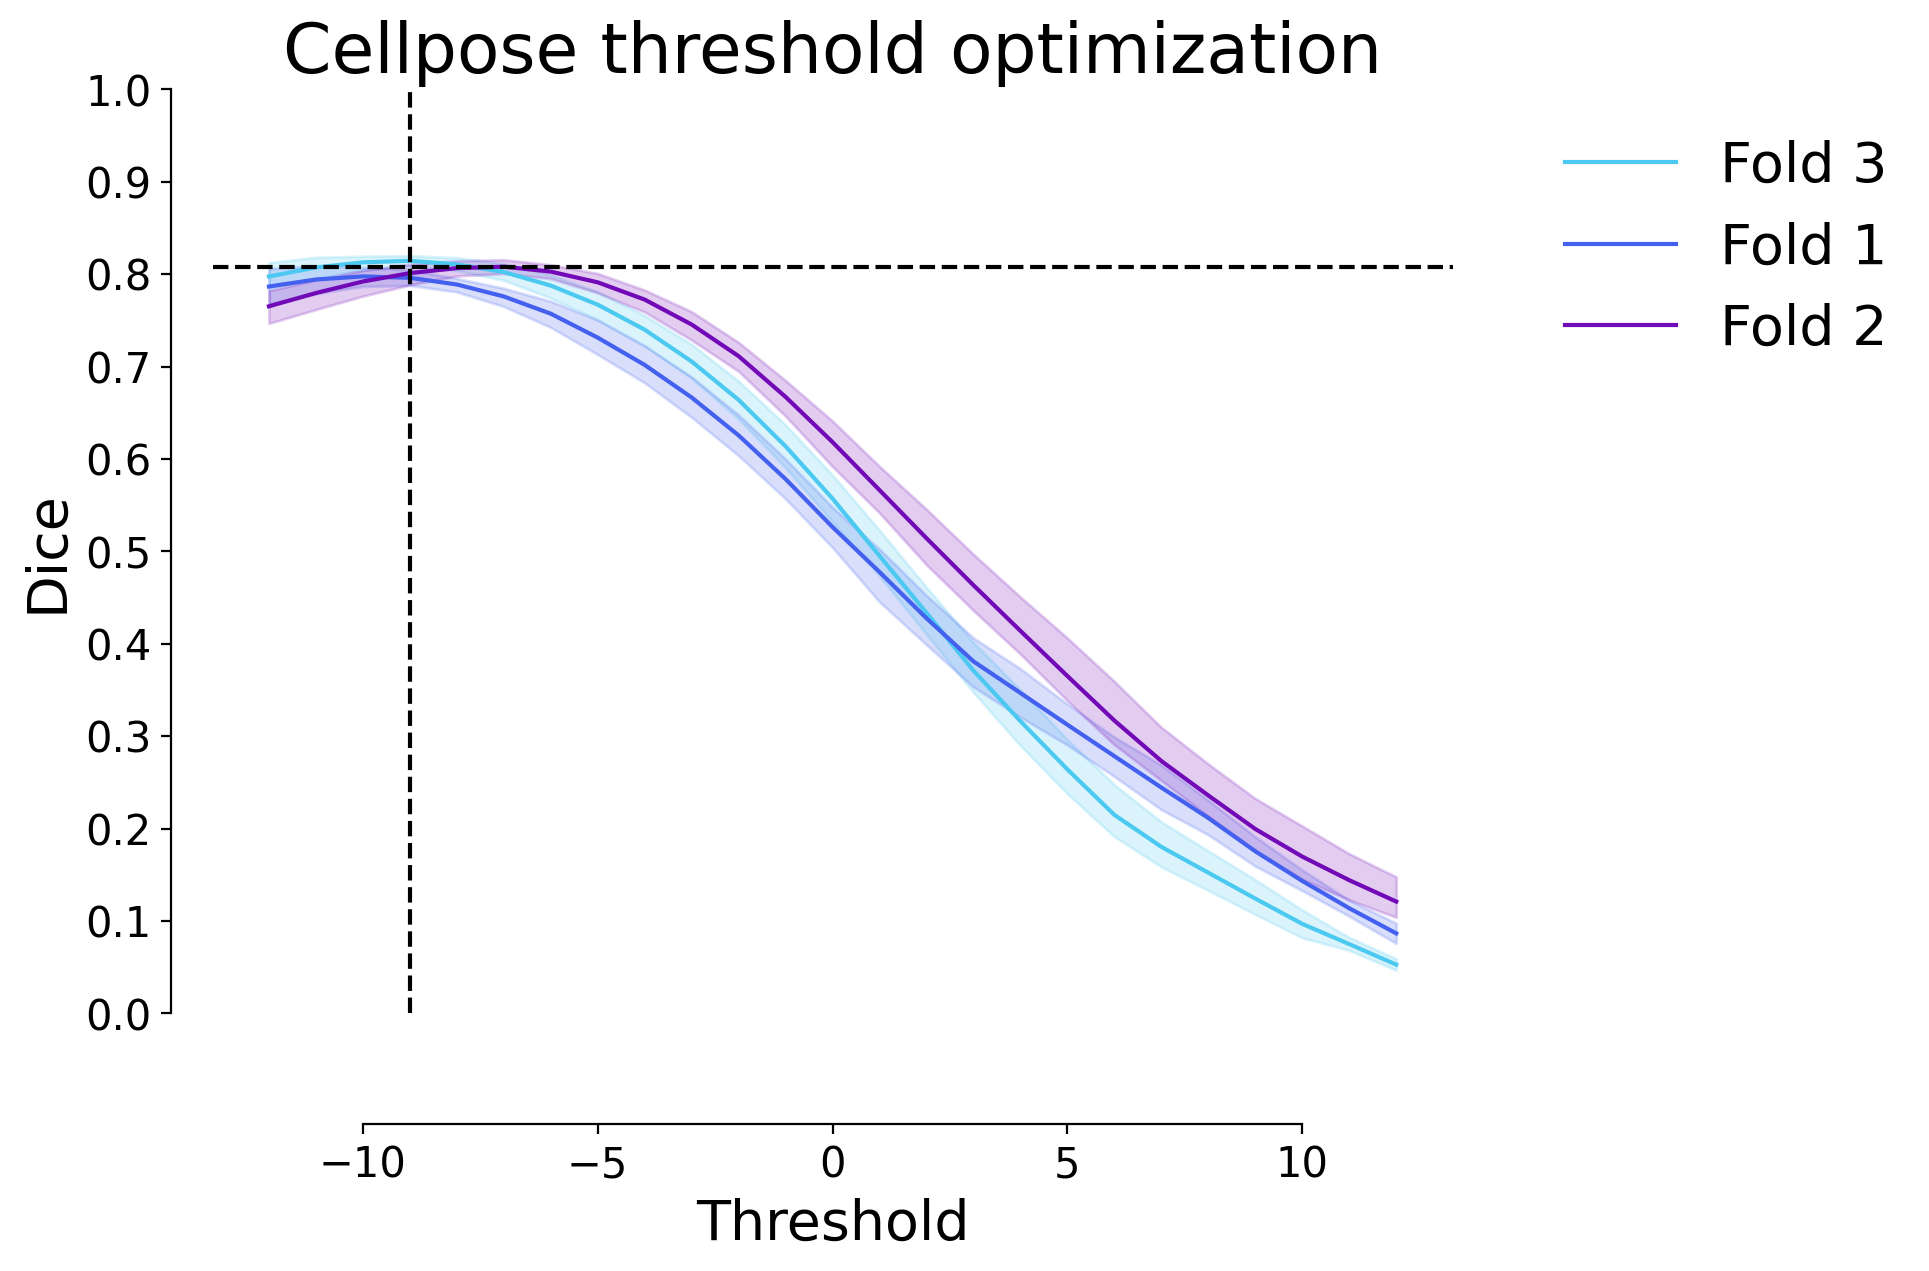

In [16]:
plot_threshold_optimization(
    dices_df, "Threshold", "Dice", "Fold", title="Cellpose threshold optimization", vline_xs=[-9]
)
if SAVE_AS_PNG:
    plt.savefig("cellpose_threshold_optimization.png")
if SAVE_AS_SVG:
    plt.savefig("cellpose_threshold_optimization.svg", format="svg", bbox_inches="tight")